In [9]:
#Importing the libraries

from numpy import mean
from numpy import std
from matplotlib import pyplot #plot accuracy & loss curves
from sklearn.model_selection import KFold 
from keras.datasets import mnist 
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

In [8]:
#Load the train and test data set from mnist

def load_dataset():
  (trainX, trainY), (testX, testY) = mnist.load_data() #this will store the x = pixel values and y = labels. 10 labels with 28 x 28 pixels. This will save data into our variables
  #this function already splits the data into sets
  trainX = trainX.reshape((-1,28,28,1)) #whatever you do to the training data, you do to the test data
#our original shape was (60,000,28,28) with no channels listed. The channels tell the machine that we are working with grayscale imaging
#channel are color channel, for grey scale it is 1, for color image it is 3 (for red, blue, green), so on...
#we want to add a grayscale channel, or dimension, since the function is expecting a 4 dimensional input
  testX = testX.reshape((-1,28,28,1))
  trainY = to_categorical(trainY) 
#use this to convert our labels into one-hot representation
#(0,1,2,3,4,5,6,7,8,9) are our oringinal labels that we convert into one-hot encoding that removes algorith bias to higher numbers in the data 
#0 = (1,0,0,0,0,0,0,0,0,0), 1 = (0,1,0,0,0,0,0,0,0,0), etc.
  testY = to_categorical(testY)
  return trainX, trainY, testX, testY


In [7]:
#Standardization (scaling the features/pixels)

def prep_pixels(train, test):
  train_norm = train.astype('float32') #covert integers into float to later divide by a floating point number. This adds a decimal point and a 0 at the end
  test_norm = test.astype('float32')
  train_norm = train_norm/255.0 #here we are normalizing the values of the pixels to place them in between [0,1]
  test_norm = test_norm/255.0
  return train_norm, test_norm

In [6]:
#Define the architecture of our CNN
#def define_model(): 
  #define the model and its layers
  #model = Sequential() #calling on the Sequential class
  #model.add(Conv2D(32, (3,3), activation='relu', kernal_initializer='he_uniform', input_shape=(28,28,1)) #adding the first layer [conv, pool, conv, pool, dense, dense]
  #model.add(MaxPooling2D((2,2))) 
  #Ask what maxpooling does
  #model.add(Flatten())#change 2D output into a 1 dimensional vector, in order to feed it into a dense layer
  #model.add(Dense(100,activation='relu',kernel_initializer='he_uniform')) #100 neurons int his layer
  #model.add(Dense(10,activation='softmax'))#10 neurons sinze we have 10 labels based off of y

  #Compile the model
  #opt = SGD(learning_rate=0.01, momentum=0.9) #this is an optimizer with chosen parameters
  #model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  #return model


In [5]:
def define_model():
  # define the model
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))
  # compile the model
  opt = SGD(learning_rate=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model


In [4]:
#Evaluate the model using K-fold CV
def evaluate_model(dataX, dataY, n_folds=5): #all the pixel values and corresponding labels
  scores, histories = list(), list() #this tells python that these variables are lists
  kfold = KFold(n_folds, shuffle=True, random_state=1) #shuffle juggles the data before we make the folds. Random_state allows for reproducability, 'seed' value
  #cross validation, dividing the training set into k sections, where we choose 1 out of the k sections as testing data, and uses the remaining sections 
  #as training data. The iterations generate a value E, that represents the training accuracy. Each fold is shifted after each iteration
  #Each iteration will produce a corresponding model test accuracy. We then take each E for k-fold, average them to get a better understanding of our accuracy
  #.split divides the data into the number of folds defined. Use the for loop to iterate over all the folds
  for train_iX, test_iX in kfold.split(dataX): 
    model = define_model()
    trainX, trainY, testX, testY = dataX[train_iX], dataY[train_iX], dataX[test_iX], dataY[test_iX]
    history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX,testY), verbose=0) #verbose reduces number of lines and hihglights the accuracy values
    _, acc = model.evaluate(testX, testY, verbose=0) #output = [0.2, 0.6]. First number is the loss, second number is the accuracy. This stores the acc value in the second spot
    print('>%0.3f' % (acc*100.0)) #want accuracy to have 3 digits after the decimal point
    scores.append(acc) #store it into the scores list. The list has 5 elements which will be the accuracy of each fold
    histories.append(history) #Same here
  return scores, histories

In [3]:
# Plot the curves

def summarize_diagnostics(histories): #histories is an array with 5 elements
  for i in range(len(histories)):
    pyplot.subplot(2,1,1) #plotting 2 plots in 1 figure. 2 plots 1 column, 2 rows
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(histories[i].history['loss'], color='blue', label='train')
    pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
    
    pyplot.subplot(2,1,2)    
    pyplot.title('Classification Accuracy')
    pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
    pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
  pyplot.show()

In [2]:
#Summarize the Model Performance 

def summarize_performance(scores): #take the scores array
  print('Accuracy: mean=%0.3f, std=%0.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
  pyplot.boxplot(scores) # this represents the highest value, the lowest value and the median value with orange line, the 75th then 25th percentile
  pyplot.show()

In [1]:
#Run the test harness for evaluating model using the test set

def run_test_harness():
  trainX, trainY, testX, testY = load_dataset() #loading mnist
  trainX, testX = prep_pixels(trainX, testX) #pixel values for train and test set
  scores, histories = evaluate_model(trainX, trainY,n_folds=5) #n_folds are still 5 from previous
  summarize_diagnostics(histories)
  summarize_performance(scores) #print the accuracy values

>98.417
>98.567
>98.633
>98.692
>98.867


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


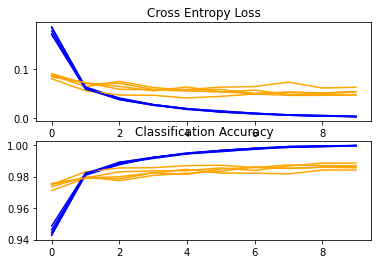

Accuracy: mean=98.635, std=0.148, n=5


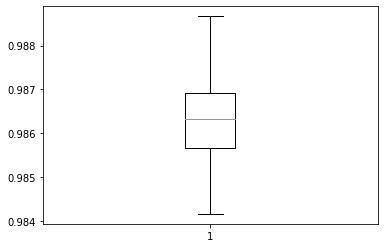

In [ ]:
# Run the test harness function
run_test_harness()